# Train ADAGE models on RNAseq data

### Georgia Doing 2021

This notebook walks through the training of an RNAseq-based ADAGE model as a continuation of analyses from last year (2021_06_eADAGE_adapt/seqADAGE).

Since then we have downloaded a new compendium of RNAseq data and aligned it to the PAO1 and PA14 reference genomes using prokarytoic-optimized parameters.
(https://github.com/hoganlab-dartmouth/pa-seq-compendia)

The main objectives are to train models, take a first look and save the models for further analysis on forthcoming notebooks
1. Load compendia
2. Train and save models
3. Visualize first-look plots

### 0. Setup

In [2]:
import run_count_autoencoder
import run_model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imp import reload
import Adage
import TiedWeightsEncoder

In [12]:
# for dev purposes, while updating run_model.py need to reload
sns.reset_orig()
reload(run_count_autoencoder)
reload(run_model)
reload(Adage)
reload(TiedWeightsEncoder)

<module 'TiedWeightsEncoder' from '/home/georgia/Dropbox (Hogan Lab)/Digital_notebook/2021_04_23_seqADAGE/seqADAGE/Py/TiedWeightsEncoder.py'>

### 1. Load Compendia

In [3]:
array_comp = pd.read_csv(open('../data_files/train_set_normalized.csv', "rb"),index_col=0)
print(array_comp.shape)

(5549, 950)


In [4]:
seq_comp_floor = pd.read_csv(open('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_floor.csv', "rb"),index_col=0)
print(seq_comp_floor.shape)

(5563, 2767)


In [5]:
seq_comp = pd.read_csv(open('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01.csv', "rb"),index_col=0)
print(seq_comp.shape)

(5563, 2766)


<AxesSubplot:ylabel='Density'>

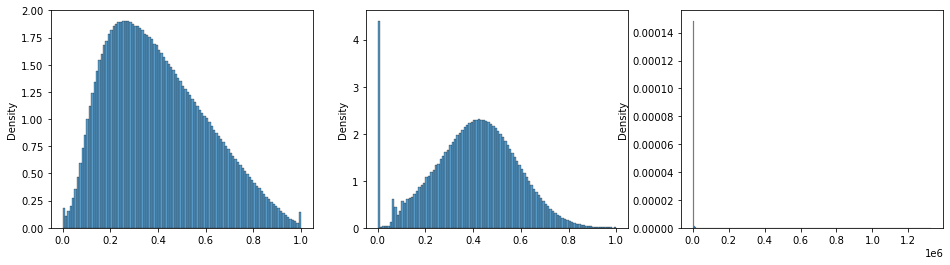

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16 ,4))
sns.histplot(array_comp.to_numpy().flatten(),binwidth=0.01, stat='density',ax=ax1)
sns.histplot(seq_comp.to_numpy().flatten(),binwidth=0.01,stat='density',ax=ax2)
sns.histplot(seq_comp_floor.to_numpy().flatten(), bins=200,stat='density',ax=ax3)

### 2. Train Models

In [10]:
ma = run_model.run_model('../data_files/train_set_normalized.csv',lr=.5,seed=560,kl1=0,kl2=0,act = 'sigmoid', tied = True, epochs=5, init='glorot_uniform', batch_size=10,v=1)


tensorflow
(5549, 950)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 300)               1665000   
_________________________________________________________________
tied_weights_encoder_2 (Tied (None, 5549)              1665000   
Total params: 1,665,000
T

In [17]:
mc = run_count_autoencoder.run_count_autoencoder('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log.csv',lr=.0001,seed=560,kl1=1e-10,kl2=1e-1, act = 'relu', tied = True, epochs=20, init='glorot_uniform', batch_size=10)


tensorflow
(5563, 2766)
Epoch 1/20
249/249 [==============================] - 8s 29ms/step - loss: 39.4698 - val_loss: 7.9528
Epoch 2/20
249/249 [==============================] - 7s 29ms/step - loss: 7.0670 - val_loss: 7.0632
Epoch 3/20
249/249 [==============================] - 8s 31ms/step - loss: 6.8062 - val_loss: 7.0636
Epoch 4/20
249/249 [==============================] - 9s 37ms/step - loss: 6.8042 - val_loss: 7.0629
Epoch 5/20
249/249 [==============================] - 8s 32ms/step - loss: 6.8060 - val_loss: 7.0642
Epoch 6/20
249/249 [==============================] - 8s 33ms/step - loss: 6.8099 - val_loss: 7.0635
Epoch 7/20
249/249 [==============================] - 13s 54ms/step - loss: 6.8047 - val_loss: 7.0632
Epoch 8/20
249/249 [==============================] - 15s 59ms/step - loss: 6.8043 - val_loss: 7.0629
Epoch 9/20
249/249 [==============================] - 15s 59ms/step - loss: 6.8049 - val_loss: 7.0630
Epoch 10/20
249/249 [==============================] - 13s 53ms

In [336]:
mc = run_count_autoencoder.run_count_autoencoder('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm.csv',lr=.01,seed=560,kl1=1e-10,kl2=1e-1, act = 'relu', tied = True, epochs=250, init='glorot_uniform', batch_size=10)
ma = run_model.run_model('../data_files/train_set_normalized.csv',lr=.5,seed=560,kl1=0,kl2=0,act = 'sigmoid', tied = True, epochs=250, init='glorot_uniform', batch_size=10,v=0)
m = run_model.run_model('../data_files/pao1_aligned_rnaseq_compendium_zp2_MRnorm_log_01.csv',lr=.5,seed=560,kl1=0,kl2=0,act = 'sigmoid', tied = True, epochs=250, init='glorot_uniform', batch_size=10,v=0)

tf_adage = Adage.Adage(ma.autoencoder, ma.history, ma.compendium)
tf_weights = np.array(pd.read_csv('../outputs/ADAGE_OG_weights.csv', header = None))
tf_cost = pd.read_csv('../outputs/ADAGE_OG_cost_log.csv')
tf_adage.weights = tf_weights
tf_adage.loss = tf_cost['cost']
tf_adage.val_loss = tf_cost['cost']
tf_adage.set_hwg_cutoff(2.5).shape

tensorflow
(5563, 2767)


/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/250
249/249 [==============================] - 13s 49ms/step - loss: 1029.9505 - val_loss: 475.0901
Epoch 2/250
249/249 [==============================] - 12s 48ms/step - loss: 583.1911 - val_loss: 496.4653
Epoch 3/250
249/249 [==============================] - 16s 65ms/step - loss: 569.6410 - val_loss: 473.6163
Epoch 4/250
249/249 [==============================] - 11s 45ms/step - loss: 575.4872 - val_loss: 478.4141
Epoch 5/250
249/249 [==============================] - 12s 46ms/step - loss: 575.2175 - val_loss: 455.8109
Epoch 6/250
249/249 [==============================] - 11s 46ms/step - loss: 574.5138 - val_loss: 465.8002
Epoch 7/250
249/249 [==============================] - 15s 62ms/step - loss: 575.7801 - val_loss: 462.8036
Epoch 8/250
249/249 [==============================] - 13s 53ms/step - loss: 588.3396 - val_loss: 478.6467
Epoch 9/250
249/249 [==============================] - 13s 51ms/step - loss: 560.3399 - val_loss: 474.3043
Epoch 10/250
249/249 [==============

249/249 [==============================] - 12s 47ms/step - loss: 547.8823 - val_loss: 468.7946
Epoch 143/250
249/249 [==============================] - 11s 46ms/step - loss: 546.1611 - val_loss: 468.7946
Epoch 144/250
249/249 [==============================] - 11s 45ms/step - loss: 551.4997 - val_loss: 468.7946
Epoch 145/250
249/249 [==============================] - 12s 46ms/step - loss: 561.5806 - val_loss: 468.7946

Epoch 00145: ReduceLROnPlateau reducing learning rate to 9.999998977483754e-17.
Epoch 146/250
249/249 [==============================] - 11s 46ms/step - loss: 568.9001 - val_loss: 468.7946
Epoch 147/250
249/249 [==============================] - 11s 45ms/step - loss: 567.4797 - val_loss: 468.7946
Epoch 148/250
249/249 [==============================] - 11s 45ms/step - loss: 559.6172 - val_loss: 468.7946
Epoch 149/250
249/249 [==============================] - 11s 45ms/step - loss: 547.6755 - val_loss: 468.7946
Epoch 150/250
249/249 [==============================] - 11s 

249/249 [==============================] - 11s 44ms/step - loss: 540.2704 - val_loss: 468.7946
Epoch 213/250
249/249 [==============================] - 11s 45ms/step - loss: 555.3955 - val_loss: 468.7946
Epoch 214/250
249/249 [==============================] - 11s 45ms/step - loss: 551.2174 - val_loss: 468.7946
Epoch 215/250
249/249 [==============================] - 11s 45ms/step - loss: 563.1577 - val_loss: 468.7946

Epoch 00215: ReduceLROnPlateau reducing learning rate to 9.999999682655227e-24.
Epoch 216/250
249/249 [==============================] - 11s 45ms/step - loss: 553.3838 - val_loss: 468.7946
Epoch 217/250
249/249 [==============================] - 11s 45ms/step - loss: 554.8392 - val_loss: 468.7946
Epoch 218/250
249/249 [==============================] - 11s 44ms/step - loss: 564.4805 - val_loss: 468.7946
Epoch 219/250
249/249 [==============================] - 12s 47ms/step - loss: 548.6083 - val_loss: 468.7946
Epoch 220/250
249/249 [==============================] - 11s 

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


test
tensorflow
(5549, 950)
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 300)               1665000   
_________________________________________________________________
module_wrapper_69 (ModuleWra (None, 5549)              1665000   
Total params: 1,665,000
Trainable params: 1,665,000
Non-trainable params: 0
_________________________________________________________________
[572 823 446 522]
(5549, 300)
test
tensorflow
(5563, 2766)
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 300)               1669200   
_________________________________________________________________
module_wrapper_70 (ModuleWra (None, 5563)              1669200   
Total params: 1,669,200
Trainable params: 1,669,200
Non-trainable

(5549, 600)

### 3. First-look plots

#### Training Loss Curves and Node Weight Distributions

t_adage
k_adage
k_da
k_dca


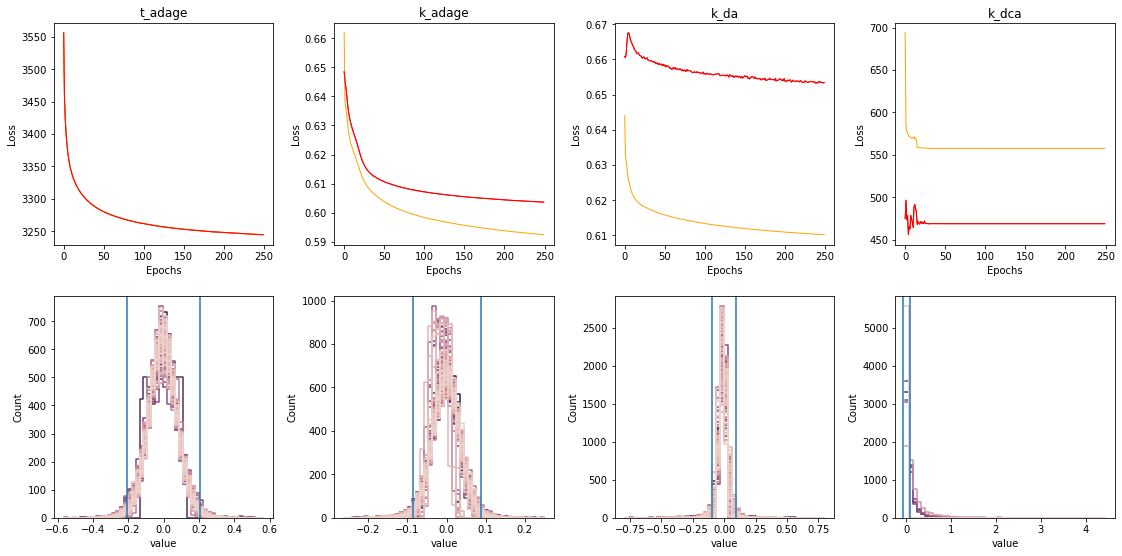

In [337]:
model_dict = {
    "t_adage": tf_adage,
    "k_adage": ma,
    "k_da" : m,
    "k_dca": mc
}
fig, ax = plt.subplots(2, 4,figsize=(16 ,8))
fig.tight_layout(pad=3.0)

eps = 250
i=0
for mo in model_dict.keys():
    print(mo)
    model_temp = model_dict[mo]
    ax[0,i].plot(list(range(0,eps)), model_temp.val_loss[0:eps], linewidth=1, markersize=2, color = 'red')
    ax[0,i].plot(list(range(0,eps)), model_temp.loss[0:eps], linewidth=1, markersize=2, color = 'orange')
    ax[0,i].plot(list(range(0,eps)), model_temp.val_loss[0:eps], linewidth=1, markersize=2, color = 'red')
    ax[0,i].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
    ax[0,i].set(title = mo)
    
    sns.histplot(pd.melt(pd.DataFrame(model_temp.weights[:,0:300])),
             x='value', hue='variable', legend=False,element='step',fill=False,
             ax=ax[1,i], bins=50)
    ax[1,i].axvline(x = np.std(model_temp.weights)*2.5)
    ax[1,i].axvline(x = np.std(model_temp.weights)*-2.5)
    i = i+1

### Wrap-up thoughts

These models do not appear to be training, even that trained on array data. This is frustrating since last year this same code trained models on both the array and refine.bio rnaseq compendia OK. Since then the only changes have been those involved in the update of python and keras/tensorflow. 


These models seem to be training faster than the ones last year and I wonder if that is an indication of a change in the datatypes, loss function or optimizer. 

In [338]:
model_dict = {
    "t_adage": tf_adage,
    "k_adage": ma,
    "k_da" : m,
    "k_dca": mc
}

plimo=10
for mo in model_dict:
    model_dict[mo].set_hwg_cutoff(2.5)
    model_dict[mo].set_op('../node_interpretation/operons_format.txt')
    x = ((model_dict[mo].ops_ps > plimo).sum(0) > 0).sum()
    y = ((model_dict[mo].ops_ps > plimo).sum(1) > 0).sum()
    print(mo + ": " + str(x) + " sigs w/ ops , " + str(y) + " ops w/ sigs")

t_adage: 210 sigs w/ ops , 416 ops w/ sigs
k_adage: 204 sigs w/ ops , 436 ops w/ sigs
k_da: 159 sigs w/ ops , 448 ops w/ sigs
k_dca: 10 sigs w/ ops , 300 ops w/ sigs


In [341]:
mo = "k_dca"
model_dict[mo].set_hwg_cutoff(3)
model_dict[mo].set_op('../node_interpretation/operons_format.txt')
x = ((model_dict[mo].ops_ps > plimo).sum(0) > 0).sum()
y = ((model_dict[mo].ops_ps > plimo).sum(1) > 0).sum()
print(mo + ": " + str(x) + " sigs w/ ops , " + str(y) + " ops w/ sigs")

k_dca: 9 sigs w/ ops , 300 ops w/ sigs
